# Decision Trees

Visualizing the decision trees in this notebook requires the <b>pydotplus</b> package; open up an Anaconda prompt, and enter:

```
conda install pydotplus
```

And then restart this notebook's kernel, if you haven't already.

We'll start illustrating decision trees using an example that doesn't involve cars at all, but is a better example of the sorts of problems decision trees are suited for. First we'll load some fake data on past hires within a company I made up, and see if we can construct a decision tree to predict if a candidate will be hired based on their attributes. Note how we use pandas to convert a csv file into a DataFrame:

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree

input_file = "http://media.sundog-soft.com/SelfDriving/PastHires.csv"
df = pd.read_csv(input_file, header = 0)

In [2]:
df.head()

,Years Experience,Employed?,Previous employers,Level of Education,Top-tier school,Interned,Hired
0,10,Y,4,BS,N,N,Y
1,0,N,0,BS,Y,Y,Y
2,7,N,6,BS,N,N,N
3,2,Y,1,MS,Y,N,Y
4,20,N,2,PhD,Y,N,N


scikit-learn needs everything to be numerical for decision trees to work. So, we'll map Y,N to 1,0 and levels of education to some scale of 0-2. In the real world, you'd need to think about how to deal with unexpected or missing data! By using map(), we know we'll get NaN for unexpected values.

In [3]:
d = {'Y': 1, 'N': 0}
df['Hired'] = df['Hired'].map(d)
df['Employed?'] = df['Employed?'].map(d)
df['Top-tier school'] = df['Top-tier school'].map(d)
df['Interned'] = df['Interned'].map(d)
d = {'BS': 0, 'MS': 1, 'PhD': 2}
df['Level of Education'] = df['Level of Education'].map(d)
df.head()

,Years Experience,Employed?,Previous employers,Level of Education,Top-tier school,Interned,Hired
0,10,1,4,0,0,0,1
1,0,0,0,0,1,1,1
2,7,0,6,0,0,0,0
3,2,1,1,1,1,0,1
4,20,0,2,2,1,0,0


Next we need to separate the features from the target column that we're trying to bulid a decision tree for.

In [4]:
features = list(df.columns[:6])
features

['Years Experience',
 'Employed?',
 'Previous employers',
 'Level of Education',
 'Top-tier school',
 'Interned']

Now actually construct the decision tree:

In [5]:
y = df["Hired"]
X = df[features]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,y)

... and display it. Note you need to have pydotplus installed for this to work. (!pip install pydotplus)

To read this decision tree, each condition branches left for "true" and right for "false". When you end up at a value, the value array represents how many samples exist in each target value. So value = [0. 5.] mean there are 0 "no hires" and 5 "hires" by the tim we get to that point. value = [3. 0.] means 3 no-hires and 0 hires.

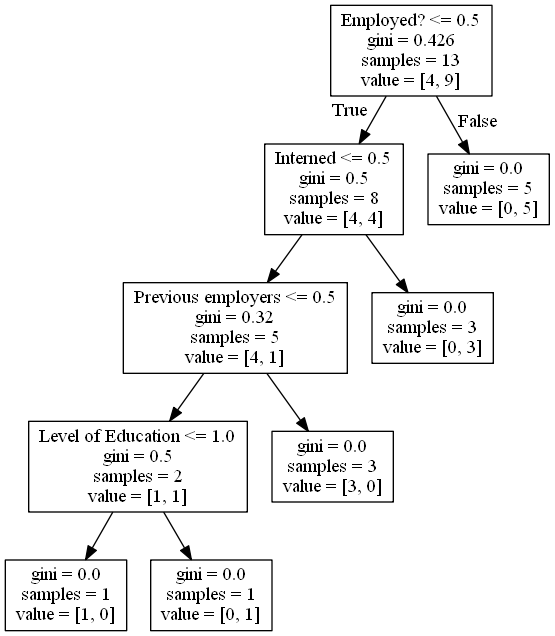

In [7]:
from IPython.display import Image  
from io import StringIO  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

## Ensemble learning: using a random forest

We'll use a random forest of 10 decision trees to predict employment of specific candidate profiles:

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, y)

#Predict employment of an employed 10-year veteran
print (clf.predict([[10, 1, 4, 0, 0, 0]]))
#...and an unemployed 10-year veteran
print (clf.predict([[10, 0, 4, 0, 0, 0]]))

[1]
[0]


Now, let's see if a decision tree works out for the classification problem we introduced in the Logistic Regression sample: predicting if a car should travel fast or slow based on the size and distance of an upcoming bump in the road. We'll start by fabricating our data set in the exact same way as before:

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs

n_samples = 10000

# To generate our fabricated data set, we'll create two blobs of
# randomly distributed data at two corners of the graph...
centers = [(0.9, 0.05), (0.05, 0.94)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=0.4,
                  centers=centers, shuffle=False, random_state=42)

# Then filter out only the values that lie within [0,1]:
features = []
labels = []
for feature, label in zip(X, y):
    if (feature[0] >= 0 and feature[0] <= 1.0 and feature[1] >= 0 and feature[1] <= 1.0):
        features.append(feature)
        labels.append(label)

# And convert the results back into numpy arrays:
X = np.array(features)
y = np.array(labels)

Now, let's see what sort of decision tree we end with for this data:

In [10]:
clf = tree.DecisionTreeClassifier()
clf.fit(X,y)

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=['Distance', 'Bump Size'])  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

Wow, that's incredibly complicated! Given the very simple relationship that's inherent in the data (go slower when you get close to a big bump,) this really looks like overfitting. Let's plot the categorizations this decision tree model results in so we can visualize just how badly it is overfitting:

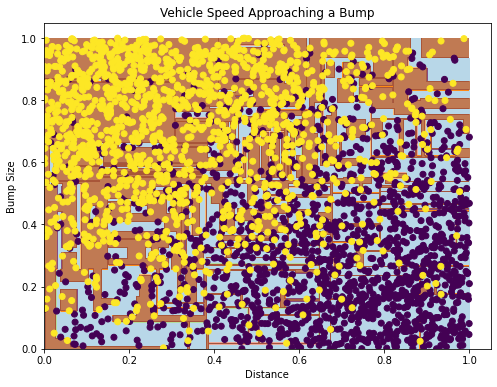

In [11]:
def plotPredictions(clf):
    xx, yy = np.meshgrid(np.arange(0, 1.0, 0.001),
                     np.arange(0, 1.0, 0.001))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(8, 6))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))
    plt.xlabel('Distance')
    plt.ylabel('Bump Size')
    plt.title("Vehicle Speed Approaching a Bump")
    plt.show()
    
plotPredictions(clf)

Cross validation should reveal that in fact we don't have a generally useful model here; and indeed, the resulting mean accuracy is only 77%, compared to 84% with logistic regression.

In [12]:
from sklearn.model_selection import cross_val_score

fold_scores = cross_val_score(clf, X, y, cv=5)
print (fold_scores)
print (np.mean(fold_scores))

[0.77213115 0.76557377 0.76518883 0.76026273 0.77175698]
0.7669826913241271


Random forests are meant to prevent overfitting, so let's try that with our data. It does indeed result in better accuracy as measured by 5-fold cross-validation, but the simpler logistic regression model still out-performs it.

In [13]:
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, y)

fold_scores = cross_val_score(clf, X, y, cv=5)
print (fold_scores)
print (np.mean(fold_scores))

[0.82295082 0.81803279 0.80952381 0.80131363 0.81444992]
0.8132541925758432


## Activity

Modify the test data to create an alternate universe where everyone I hire everyone I normally wouldn't have, and vice versa. Compare the resulting decision tree to the one from the original data.